# GNR638  - Mini Project II


In [1]:
!pip install numpy==1.24.4 pillow==10.2 scikit-image==0.21 torch-summary

In [2]:
import os
import cv2
import sys
import json
import torch
import random
import subprocess
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torch.optim import lr_scheduler
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image

In [3]:
## Training Config
BATCH_SIZE =32
LR =0.005
EPOCHS = 10

## **Part A** - Loading Data and Resizing images

In [11]:
!wget -O train_sharp.zip https://iitbacin-my.sharepoint.com/:u:/g/personal/23d2031_iitb_ac_in/EQBj3agHPEFJiE12ohOMZvIBypuc-vJSpdYqblaFKw92rw?download=1

--2024-04-10 06:32:34--  https://iitbacin-my.sharepoint.com/:u:/g/personal/23d2031_iitb_ac_in/EQBj3agHPEFJiE12ohOMZvIBypuc-vJSpdYqblaFKw92rw?download=1
Resolving iitbacin-my.sharepoint.com (iitbacin-my.sharepoint.com)... 52.105.217.27, 2620:1ec:8f8::10, 2620:1ec:8fa::10
Connecting to iitbacin-my.sharepoint.com (iitbacin-my.sharepoint.com)|52.105.217.27|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/23d2031_iitb_ac_in/Documents/train_sharp.zip?ga=1 [following]
--2024-04-10 06:32:35--  https://iitbacin-my.sharepoint.com/personal/23d2031_iitb_ac_in/Documents/train_sharp.zip?ga=1
Reusing existing connection to iitbacin-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 34261573976 (32G) [application/x-zip-compressed]
Saving to: ‘train_sharp.zip’

train_sharp.zip     100%[===================>]  31.91G  46.4MB/s    in 12m 22s 

2024-04-10 06:44:57 (44.0 MB/s) - ‘train_sharp.zip’ saved [34261573976/34261573976]



In [12]:
!unzip -q train_sharp.zip

In [13]:
!rm -rf train_sharp.zip

In [14]:
DATA_DIR = "/content/train/train_sharp"

In [15]:
IMG_SIZE = (256,448)

transform_train = transforms.Compose([
        transforms.Resize((IMG_SIZE[0], IMG_SIZE[1])),
        transforms.ToTensor(),
        ])

# Load data from folders
train_dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform_train)
class_names = train_dataset.classes

### Some Utilities

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
def show_images_with_labels(images, class_names):
        num_images = len(images)
        rows = int(np.sqrt(num_images))
        cols = int(np.ceil(num_images / rows))
        fig, axes = plt.subplots(rows, cols)
        for i, ax in enumerate(axes.flatten()):
            if i < num_images:
                img = images[i].permute(1, 2, 0)  # Convert (C, H, W) to (H, W, C)
                ax.imshow(img)
                ax.set_title(f"Class: {class_names[i]}")
                ax.axis('off')
            else:
                ax.axis('off')
        plt.tight_layout()
        plt.show()

def visualize(dataset, class_names, indices = None, num_images = 9,):
      if not indices:
          indices = random.sample(range(len(train_dataset)), num_images)
      images, labels = [], []
      for index in indices:
          image, label = dataset[index]
          images.append(image)
          labels.append(label)
      class_labels = [class_names[label] for label in labels]
      show_images_with_labels(images, class_labels)

In [18]:
def PSNR(input, target, EPS=1e-6):
    return -10*torch.log10(torch.mean((input - target) ** 2, dim=[1, 2, 3])+EPS)

In [19]:
def MSE(input, target):
    return torch.mean((input - target) ** 2, dim=[1, 2, 3])

## **Part B** - Apply gaussain kernels

In [20]:
# Custom transformation to apply Gaussian filter to each image
class ApplyGaussianFilter(object):
    def __init__(self, kernel_size, sigma):
        self.kernel_size = kernel_size
        self.sigma = sigma

    def __call__(self, img):
        img_np = np.array(img)
        img_filtered = cv2.GaussianBlur(img_np, (self.kernel_size, self.kernel_size), self.sigma)
        img_filtered = Image.fromarray(img_filtered)
        return img_filtered

# Define transformations
transform_gaussian_3x3 = transforms.Compose([
    transforms.Resize((IMG_SIZE[0], IMG_SIZE[1])),
    ApplyGaussianFilter(kernel_size=3, sigma=0.3),
    transforms.ToTensor()
])

transform_gaussian_7x7 = transforms.Compose([
    transforms.Resize((IMG_SIZE[0], IMG_SIZE[1])),
    ApplyGaussianFilter(kernel_size=7, sigma=1),
    transforms.ToTensor()
])

transform_gaussian_11x11 = transforms.Compose([
    transforms.Resize((IMG_SIZE[0], IMG_SIZE[1])),
    ApplyGaussianFilter(kernel_size=11, sigma=1.6),
    transforms.ToTensor()
])

# Apply transformations to your dataset
dataset_gaussian_3x3 = datasets.ImageFolder(root=DATA_DIR, transform=transform_gaussian_3x3)
dataset_gaussian_7x7 = datasets.ImageFolder(root=DATA_DIR, transform=transform_gaussian_7x7)
dataset_gaussian_11x11 = datasets.ImageFolder(root=DATA_DIR, transform=transform_gaussian_11x11)

# train_loader_3x3 = DataLoader(dataset_gaussian_3x3, batch_size=8, shuffle=False)
# train_loader_7x7 = DataLoader(dataset_gaussian_7x7, batch_size=8, shuffle=False)
# train_loader_11x11 = DataLoader(dataset_gaussian_11x11, batch_size=8, shuffle=False)

### Visualization

In [21]:
indices = random.sample(range(len(train_dataset)), 9)

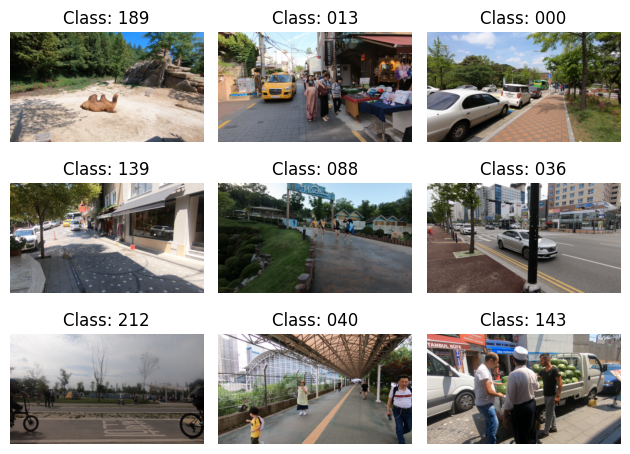

In [22]:
visualize(train_dataset, class_names, indices)

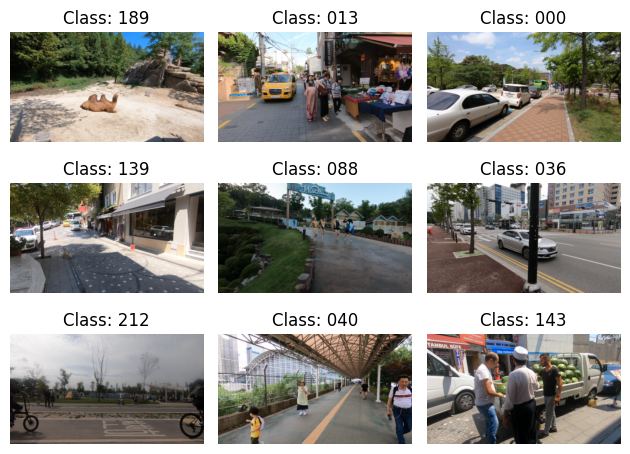

In [23]:
visualize(dataset_gaussian_3x3, class_names, indices)

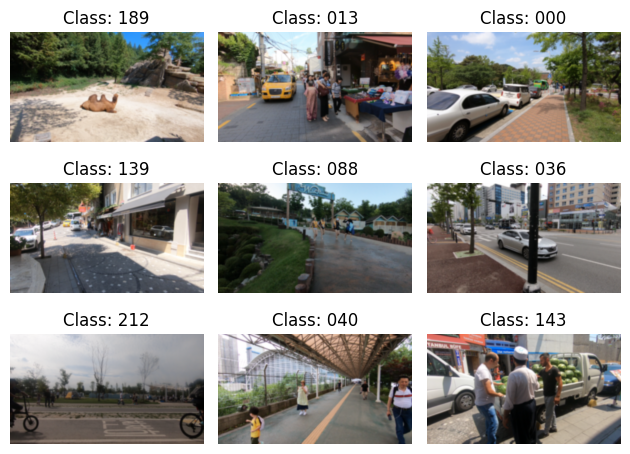

In [24]:
visualize(dataset_gaussian_7x7, class_names, indices)

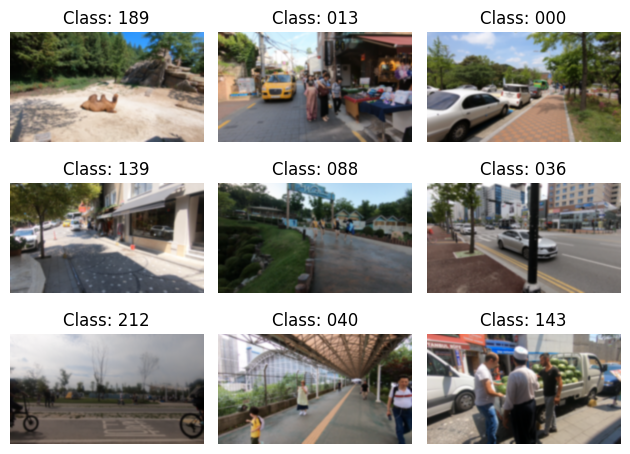

In [25]:
visualize(dataset_gaussian_11x11, class_names,indices)

In [53]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

# Define transformations
transform_original = transforms.Compose([
        transforms.Resize((IMG_SIZE[0], IMG_SIZE[1])),
        transforms.ToTensor(),
        ])
transform_gaussian_3x3 = transforms.Compose([
    transforms.Resize((IMG_SIZE[0], IMG_SIZE[1])),
    ApplyGaussianFilter(kernel_size=3, sigma=0.3),
    transforms.ToTensor()
])

transform_gaussian_7x7 = transforms.Compose([
    transforms.Resize((IMG_SIZE[0], IMG_SIZE[1])),
    ApplyGaussianFilter(kernel_size=7, sigma=1),
    transforms.ToTensor()
])

transform_gaussian_11x11 = transforms.Compose([
    transforms.Resize((IMG_SIZE[0], IMG_SIZE[1])),
    ApplyGaussianFilter(kernel_size=11, sigma=1.6),
    transforms.ToTensor()
])

class DenoisingDataset(Dataset):
    def __init__(self, root, transform=None):
        """
        root: Path to the folder where the original dataset is located.
        transform: Optional transform to be applied on a sample.
        """
        self.transform = transform
        self.original_dataset = datasets.ImageFolder(root=root, transform=transform)
        # Apply transformations to your dataset
        self.dataset_gaussian_3x3 = datasets.ImageFolder(root=DATA_DIR, transform=transform_gaussian_3x3)
        self.dataset_gaussian_7x7 = datasets.ImageFolder(root=DATA_DIR, transform=transform_gaussian_7x7)
        self.dataset_gaussian_11x11 = datasets.ImageFolder(root=DATA_DIR, transform=transform_gaussian_11x11)
        self.noisy_datasets = [self.dataset_gaussian_3x3, self.dataset_gaussian_7x7, self.dataset_gaussian_11x11]

        # Ensure all datasets are of the same size
        assert all(len(self.original_dataset) == len(noisy_dataset) for noisy_dataset in self.noisy_datasets), "Mismatch in dataset sizes"

    def __len__(self):
        # Return the total number of samples across all noise types
        return len(self.original_dataset) * 3

    def __getitem__(self, idx):
        # Calculate index for original and noisy datasets
        num_samples = len(self.original_dataset)
        noise_idx = idx // num_samples
        sample_idx = idx % num_samples

        # Get original image and label
        original_image, _ = self.original_dataset[sample_idx]
        noisy_image, _ = self.noisy_datasets[noise_idx][sample_idx]
        return noisy_image, original_image

denoising_dataset = DenoisingDataset(root=DATA_DIR, transform=transform_original)
data_loader = DataLoader(denoising_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [54]:
inputs, labels = next(iter(data_loader))

In [55]:
inputs.shape

torch.Size([32, 3, 256, 448])

In [56]:
labels.shape

torch.Size([32, 3, 256, 448])

## Denoising Auto-Encoder Architecture (U-NET)

In [57]:
import torch.nn as nn
from torch.nn import Linear, ReLU, MSELoss, L1Loss, Sequential, \
 Conv2d, ConvTranspose2d, MaxPool2d, AdaptiveAvgPool2d, Module, \
  BatchNorm2d, Sigmoid, Dropout

In [58]:
import torch
import torch.nn as nn

class DenoisingAE(nn.Module):
    def __init__(self):
        super(DenoisingAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),
            nn.ReLU(True)
      )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Create an instance of the Autoencoder
model = DenoisingAE()

In [59]:
print(summary(model, torch.zeros((1, 3,256,448))))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 32, 56]         --
|    └─Conv2d: 2-1                       [-1, 64, 256, 448]        1,792
|    └─ReLU: 2-2                         [-1, 64, 256, 448]        --
|    └─MaxPool2d: 2-3                    [-1, 64, 128, 224]        --
|    └─Conv2d: 2-4                       [-1, 128, 128, 224]       73,856
|    └─ReLU: 2-5                         [-1, 128, 128, 224]       --
|    └─MaxPool2d: 2-6                    [-1, 128, 64, 112]        --
|    └─Conv2d: 2-7                       [-1, 256, 64, 112]        295,168
|    └─ReLU: 2-8                         [-1, 256, 64, 112]        --
|    └─MaxPool2d: 2-9                    [-1, 256, 32, 56]         --
├─Sequential: 1-2                        [-1, 3, 256, 448]         --
|    └─ConvTranspose2d: 2-10             [-1, 128, 64, 112]        131,200
|    └─ReLU: 2-11                        [-1, 128, 64, 112]        -

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.optim import Adam

model.to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

def train_one_epoch(model, optimizer, criterion):
  pass

for epoch in range(EPOCHS):
    for batch in data_loader:
        optimizer.zero_grad()
        inputs,labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        # plt.imshow(inputs[0].detach().permute(1, 2, 0))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')
# Save the trained model
torch.save(model.state_dict(), 'denoising_autoencoder.pt')